In [1]:
from load_dataset.artgraph import ArtGraph
from utils.MultiTaskLinkSplitter import MultiTaskLinkSplitter
from utils.dataset import TrainingDataSet, TestDataSet, SingleTaskTestDataSet, SingleTaskTrainingDataSet
from utils.EarlyStopping import EarlyStopping
from multi_task_model import MultiTaskClassificationModel, NewMultiTaskClassificationModel
from torch import nn
from utils.training_utils import fine_tune, test as test_func, compute_topk, plot_confusion_matrix, fine_tune_single_task, test_single_task
from torch.utils.data import DataLoader
from torch import optim
import torch
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
%matplotlib inline

In [2]:
from torch_geometric.seed import seed_everything
seed_everything(1)

In [3]:
root = 'artgraph2bestemotions'
data_path = 'data_full_labels.csv'

In [4]:
data = ArtGraph(root = root, preprocess='constant', features = 'vit', fine_tuning = True)[0]
data

Processing...
Done!


HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[9, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 47] },
  (artwork, about, tag)={ edge_index=[2, 342982] },
  (artwork, createdby, artist)={ edge_index=[2, 116475] },
  (artwork, elicit, emotion)={ edge_index=[2, 65236] },
  (artwork, hasgenre, genre)

In [5]:
mls = MultiTaskLinkSplitter(seed = 1)
train, val, test = mls.transform(data)
train

HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[9, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 47] },
  (artwork, about, tag)={ edge_index=[2, 181644] },
  (artwork, createdby, artist)={ edge_index=[2, 52188] },
  (artwork, elicit, emotion)={ edge_index=[2, 52188] },
  (artwork, hasgenre, genre)=

In [6]:
#loading data with labels
data_labels = pd.read_csv(data_path)
data_labels.index = data_labels.artwork
data_labels['style'] -= 1
data_labels

,artwork,style,genre,emotion
artwork,,,,
81418,81418,0,4,4
28493,28493,2,9,5
28421,28421,2,3,8
28393,28393,2,9,8
28380,28380,2,9,7
...,...,...,...,...
71300,71300,9,6,8
68290,68290,22,6,8
68567,68567,22,6,8


In [7]:
from torch_geometric.transforms import ToUndirected
batch_size = 128
num_epochs = 50
device = torch.device('cuda:0')
train = ToUndirected()(train).to(device)

In [8]:
from model import ModelClassification
for task in ('style', 'genre', 'emotion'):
    print(f"{'*'*50}{task.upper()}{'*'*50}")
    train_dataset = SingleTaskTrainingDataSet(train, data_labels, task)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    
    val_dataset = SingleTaskTestDataSet(val, data_labels, train, task)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    
    
    out_channels = train[task].x.shape[0] if task != 'style' else 30
    model = ModelClassification(data = train, hidden_channels = 128, out_channels = out_channels,
                               obj = task, head_num_layers = 5, gnn_activation = torch.nn.Tanh(),
                               head_activation = torch.nn.LeakyReLU, drop_rate = 0.25,
                               shared=True, gnn_mean =False, bnorm=False).to(device)
    
    with torch.no_grad():
        model.encoder(train.x_dict, train.edge_index_dict)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    early_stop = EarlyStopping(patience = 5, min_delta = 1e-3, checkpoint_path = f'best_model_{task}_single_task.pt')
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-7, verbose = True, factor = .5, patience = 1,
                                               threshold = 1e-4)
    #fine_tune_single_task(model, train, train_loader, val_loader, criterion, optimizer, early_stop, scheduler,
    #                     num_epochs)

**************************************************STYLE**************************************************


D:\Anaconda\envs\tesi\lib\site-packages\torch_geometric\nn\conv\hetero_conv.py:53: UserWarning: There exist node types ({'artwork'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


**************************************************GENRE**************************************************
**************************************************EMOTION**************************************************


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 40.03it/s]


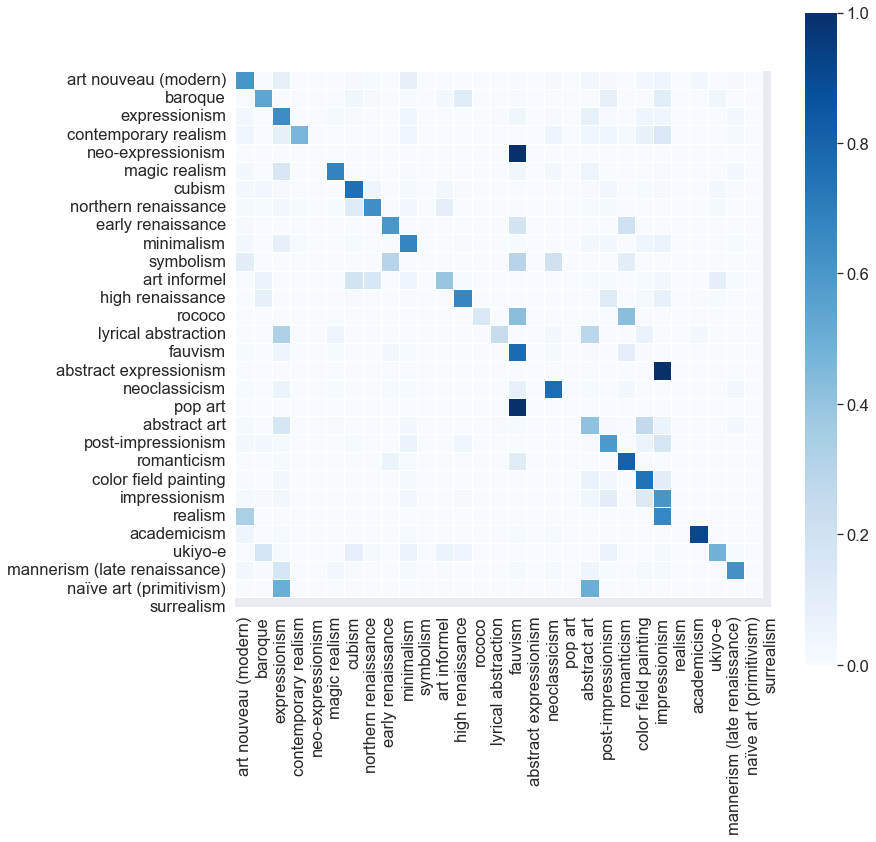

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 32.35it/s]


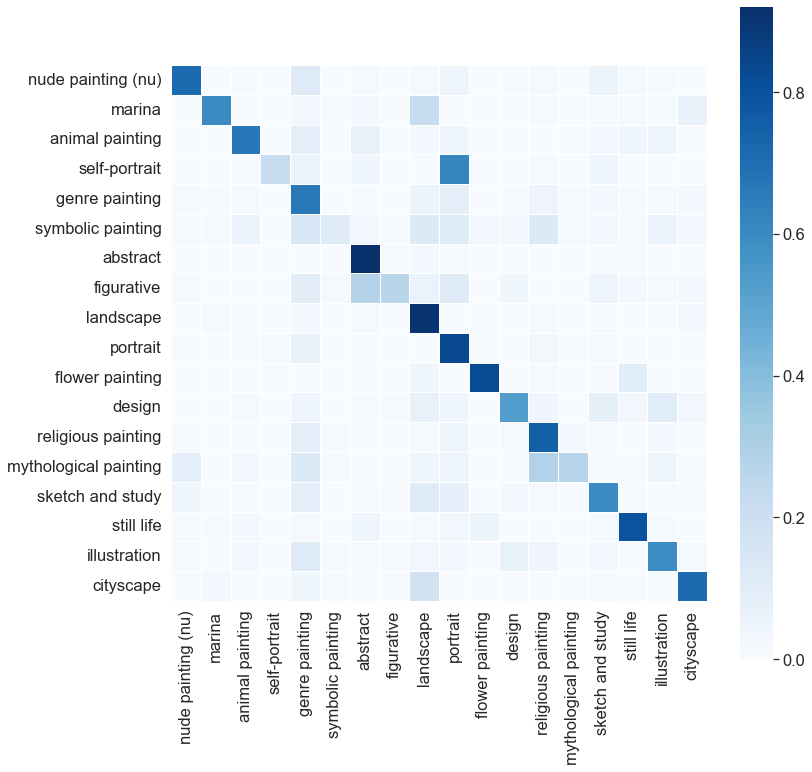

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 18.82it/s]


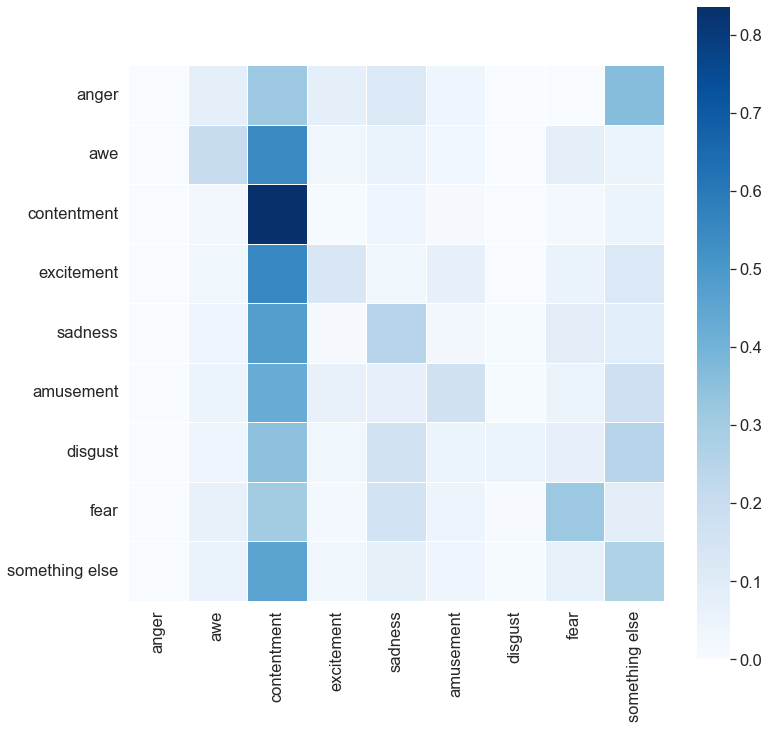

In [9]:
batch_size = 128
device = torch.device('cuda:0')
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
for task in ('style', 'genre', 'emotion'):
    test_dataset = SingleTaskTestDataSet(test, data_labels, train, task)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    model = torch.load(f'best_model_{task}_single_task.pt').to(device)
    with torch.no_grad():
        pred, lab = test_single_task(model, test_loader, train)
    results_df['Top1'].loc[task] = compute_topk(lab, pred, k=1)
    results_df['Top2'].loc[task] = compute_topk(lab, pred, k=2)
    pred_lab = torch.max(torch.Tensor(pred), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab, pred_lab, average = 'macro')
    labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    if task == 'style':
        labels = labels[1:-1]
    plot_confusion_matrix(lab, pred_lab, hop = map_hop[task], labels = labels)

In [10]:
results_df

,Top1,Top2,Macro-F1
style,0.631264,0.80659,0.486035
genre,0.744828,0.884138,0.619472
emotion,0.44751,0.632337,0.25668


In [11]:
results_df.to_csv('resuls_single_task.csv')

In [12]:
batch_size = 128
device = torch.device('cuda:0')
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
for task in ('style', 'genre', 'emotion'):
    test_dataset = SingleTaskTestDataSet(test, data_labels, train, task)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    model = torch.load(f'best_model_{task}_single_task.pt').to(device)
    with torch.no_grad():
        pred, lab = test_single_task(model, test_loader, train, update_graph=True)
    results_df['Top1'].loc[task] = compute_topk(lab, pred, k=1)
    results_df['Top2'].loc[task] = compute_topk(lab, pred, k=2)
    pred_lab = torch.max(torch.Tensor(pred), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab, pred_lab, average = 'macro')
    labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    if task == 'style':
        labels = labels[1:-1]
    #plot_confusion_matrix(lab, pred_lab, hop = map_hop[task], labels = labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 25.49it/s]


In [13]:
results_df

,Top1,Top2,Macro-F1
style,0.631111,0.80705,0.485791
genre,0.745287,0.884751,0.62064
emotion,0.448429,0.632184,0.256665


In [14]:
results_df.to_csv('resuls_single_task_update.csv')